<a href="https://colab.research.google.com/github/dgambone3/CSC4850-Machine-Learning/blob/main/FDS_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [146]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

In [148]:
# to import data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [149]:
# load dataset and drop null column
df = pd.read_csv('speeddating.csv')
drop_waves =[6, 7, 8, 9]
df = df[~df['wave'].isin(drop_waves)] # drop waves that use preference range 0-10
df = df.drop(labels=['has_null', 'field', 'wave'], axis=1)

# for col in df:
#   print(col)

df.replace("b\'?\'", np.nan, inplace=True)
print(sorted(df.columns))
diff_cols=[]
for col in df:
  if 'd_' in col:
    diff_cols.append(col)

df = df.drop(labels=diff_cols, axis=1)

### encoding object row values ###
for col in df.columns:   # output old value and encoded value for intrepretation later
  if df[col].dtype == "object":
    old_values = pd.DataFrame(columns=[]) #dataframe to hold and display values
    encoder = OrdinalEncoder()
    df[col] = encoder.fit_transform(df[[col]]) #fit transform data to encoded data
    # add to df
    old_values['encoded_value'] = pd.DataFrame(df[col].unique())
    old_values['original_value'] = pd.Series(encoder.categories_[0])
    # print('\n   ---',col,'---')
    # print(old_values.sort_values(by=['encoded_value']))


['age', 'age_o', 'ambition', 'ambition_partner', 'ambitous_o', 'ambtition_important', 'art', 'attractive', 'attractive_important', 'attractive_o', 'attractive_partner', 'clubbing', 'concerts', 'd_age', 'd_ambition', 'd_ambition_partner', 'd_ambitous_o', 'd_ambtition_important', 'd_art', 'd_attractive', 'd_attractive_important', 'd_attractive_o', 'd_attractive_partner', 'd_clubbing', 'd_concerts', 'd_d_age', 'd_dining', 'd_exercise', 'd_expected_happy_with_sd_people', 'd_expected_num_interested_in_me', 'd_expected_num_matches', 'd_funny', 'd_funny_important', 'd_funny_o', 'd_funny_partner', 'd_gaming', 'd_guess_prob_liked', 'd_hiking', 'd_importance_same_race', 'd_importance_same_religion', 'd_intellicence_important', 'd_intelligence', 'd_intelligence_o', 'd_intelligence_partner', 'd_interests_correlate', 'd_like', 'd_movies', 'd_museums', 'd_music', 'd_pref_o_ambitious', 'd_pref_o_attractive', 'd_pref_o_funny', 'd_pref_o_intelligence', 'd_pref_o_shared_interests', 'd_pref_o_sincere', '

# Preprocessing

In [150]:
# impute null values - dropping all null would significantly reduce dataset size
null = df.isnull().sum() # find amount all null values
print('Data shape before dropping null: ', df.shape)
print('Amount of null before dropping sparse cols: ', df.isnull().sum().sum())
# drop cols with more than 300 null values
drop_cols = [col for col, null_count in null.items() if null_count > 500]
print(drop_cols)
df = df.drop(columns=drop_cols)
null = df.isnull().sum()
print('\nSparse columns being dropped: ', drop_cols)
print('\nData shape after dropping null: ', df.shape)
print('Amount of null after dropping sparse cols:', df.isnull().sum().sum())

# impute null values
for column, null_count in null.items():
  if null_count != 0:
    med = df[column].median()
    df[column].fillna(med, inplace=True)


pre_data = df#.iloc[:, :-1]

#create pca and fit/transform
pca = PCA(n_components=55)
pca.fit(pre_data).transform(pre_data)

pc_components = len(pca.components_)
# get index of hightest variance for each feature/component
most_impt = [np.abs(pca.components_[i]).argmax() for i in range(pc_components)]

init_cols = pre_data.columns
pc_names = [init_cols[most_impt[i]] for i in range(pc_components)]
pc_vals = pca.components_[0]

dic = {'PC{}'.format(i): pc_names[i] for i in range(pc_components)}
final_cols = pd.DataFrame(dic.items())
final_cols['PCA Variance'] = abs(pc_vals[most_impt])
final_cols = final_cols.rename(columns={0:'Principal_Components', 1:'Feature'})\
                              .drop_duplicates(subset='Feature')
                              
temp_data = pre_data[final_cols['Feature']]

### final dataframe with no nulls, imputed values, and selected features
data = pd.concat([temp_data, df['match']], axis=1) 
print('\nFinal shape of X before beginning analysis: ', data.shape)
# for col in data:
#   if len(data[col].value_counts()) > 3:
#     print(col)
#     print(data[col].value_counts())


display(final_cols.sort_values(by=['PCA Variance'], ascending=False)) # temp print to display table later
"""
pref_o = how important partner rate attribute
d = difference between date preference/importance of attributes
"""

Data shape before dropping null:  (6816, 57)
Amount of null before dropping sparse cols:  7265
['ambitous_o', 'ambition_partner']

Sparse columns being dropped:  ['ambitous_o', 'ambition_partner']

Data shape after dropping null:  (6816, 55)
Amount of null after dropping sparse cols: 6087

Final shape of X before beginning analysis:  (6816, 45)


,Principal_Components,Feature,PCA Variance
0,PC0,attractive_important,0.658703
1,PC1,pref_o_attractive,0.630730
2,PC2,sincere_important,0.179415
3,PC3,pref_o_sincere,0.171864
6,PC6,ambtition_important,0.157032
7,PC7,pref_o_ambitious,0.152174
4,PC4,funny_important,0.044237
11,PC11,sports,0.043248
5,PC5,pref_o_funny,0.043210
31,PC31,theater,0.041881


'\npref_o = how important partner rate attribute\nd = difference between date preference/importance of attributes\n'

# Exploratory Data Analysis

In [128]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
attractive_important,6816.0,23.939327,13.375941,0.00,15.00,20.00,30.00,100.00
pref_o_attractive,6816.0,23.912185,13.350013,0.00,15.00,20.00,30.00,100.00
sincere_important,6816.0,17.327446,7.665363,0.00,10.53,20.00,20.00,60.00
pref_o_sincere,6816.0,17.331847,7.658280,0.00,10.53,20.00,20.00,60.00
funny_important,6816.0,17.360189,6.604667,0.00,14.00,18.00,20.00,50.00
pref_o_funny,6816.0,17.364151,6.601372,0.00,14.00,18.00,20.00,50.00
ambtition_important,6816.0,9.747686,6.079460,0.00,5.00,10.00,15.00,53.00
pref_o_ambitious,6816.0,9.750327,6.078314,0.00,5.00,10.00,15.00,53.00
art,6816.0,6.713762,2.279725,0.00,5.00,7.00,8.00,10.00
age,6816.0,26.278022,3.562710,18.00,24.00,26.00,28.00,55.00


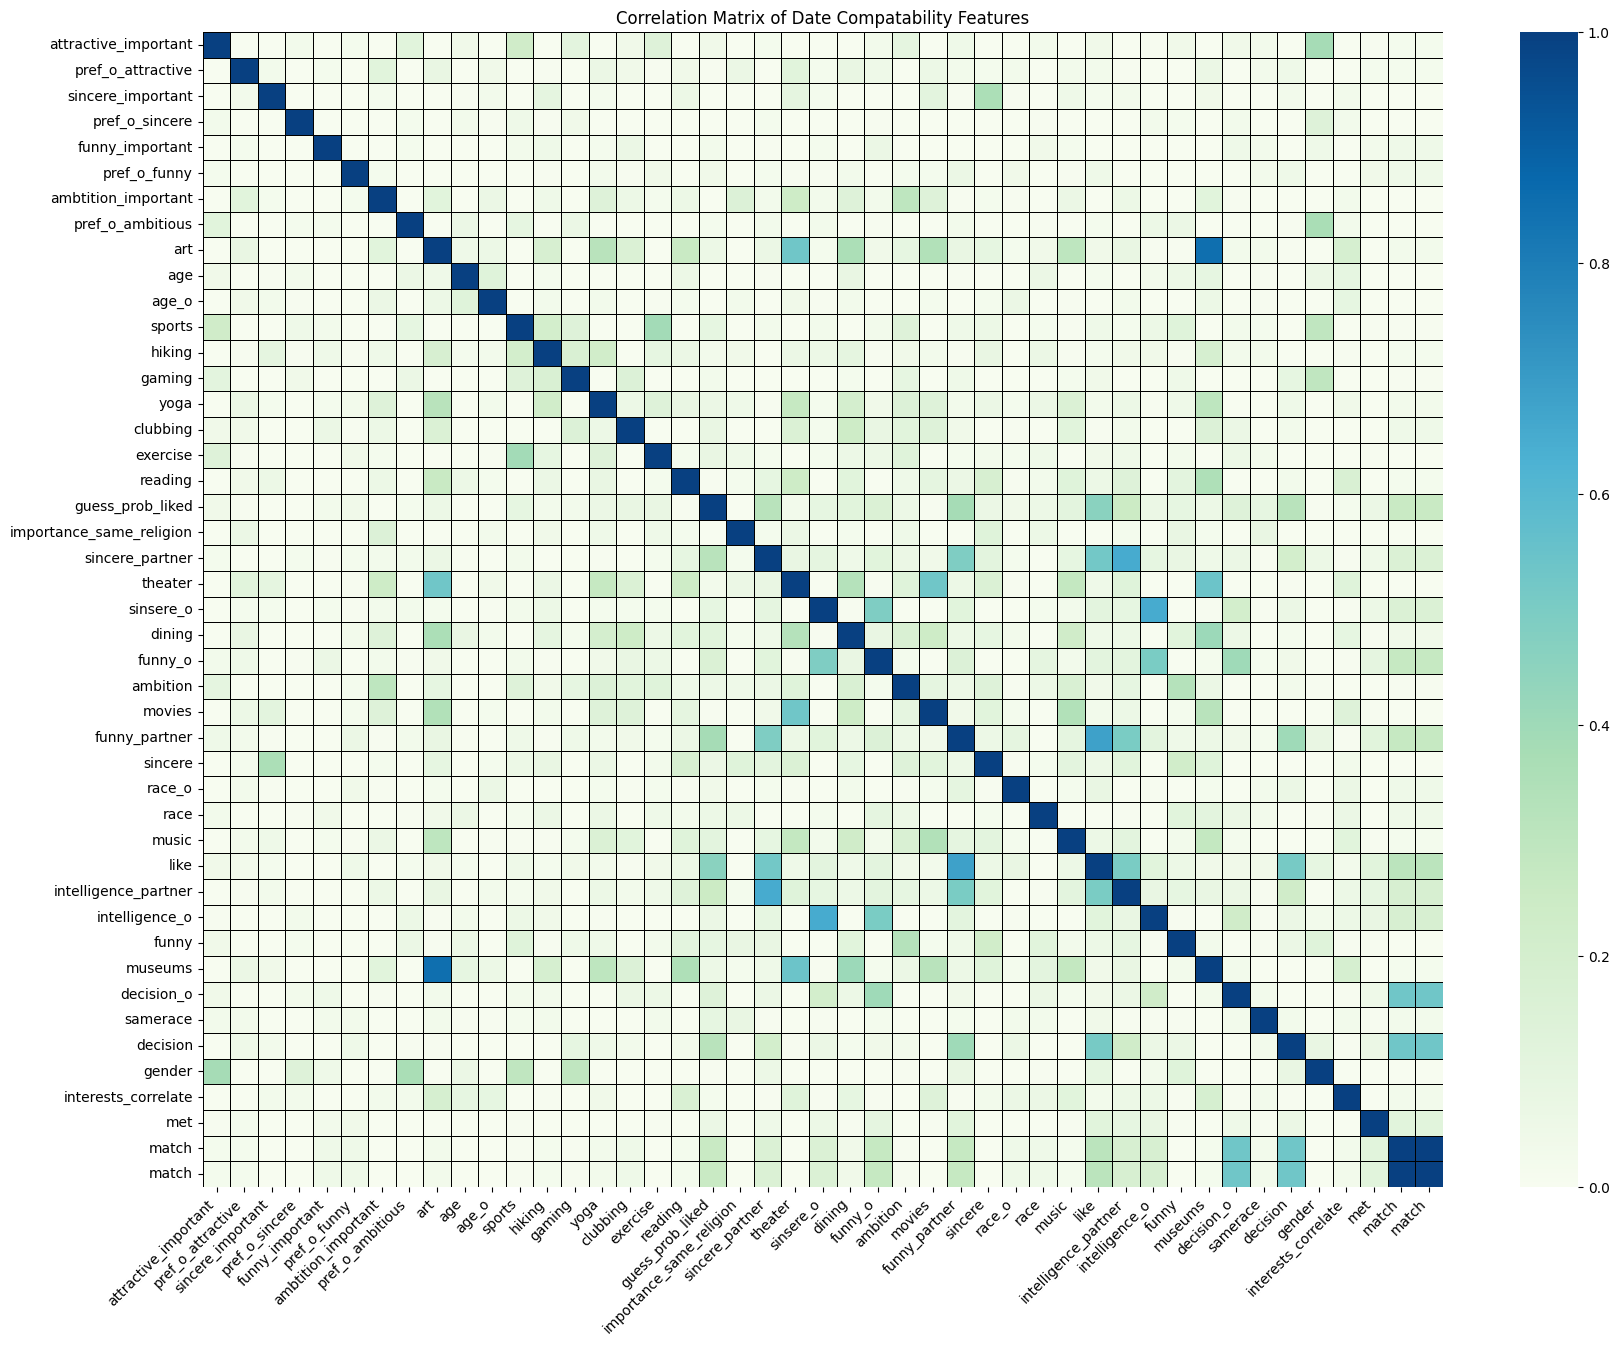

In [151]:
corr = round(data.corr(), 2)
mask = np.triu(np.ones_like(corr, dtype=bool))
fig = plt.figure(figsize=(20,15))
axes = fig.subplots()

sns.heatmap(corr, vmin=0, vmax=1, cmap='GnBu', linewidth=.5, linecolor='black')
plt.xticks(ha='right', rotation=45)
plt.title('Correlation Matrix of Date Compatability Features')
plt.show()

ValueError: ignored

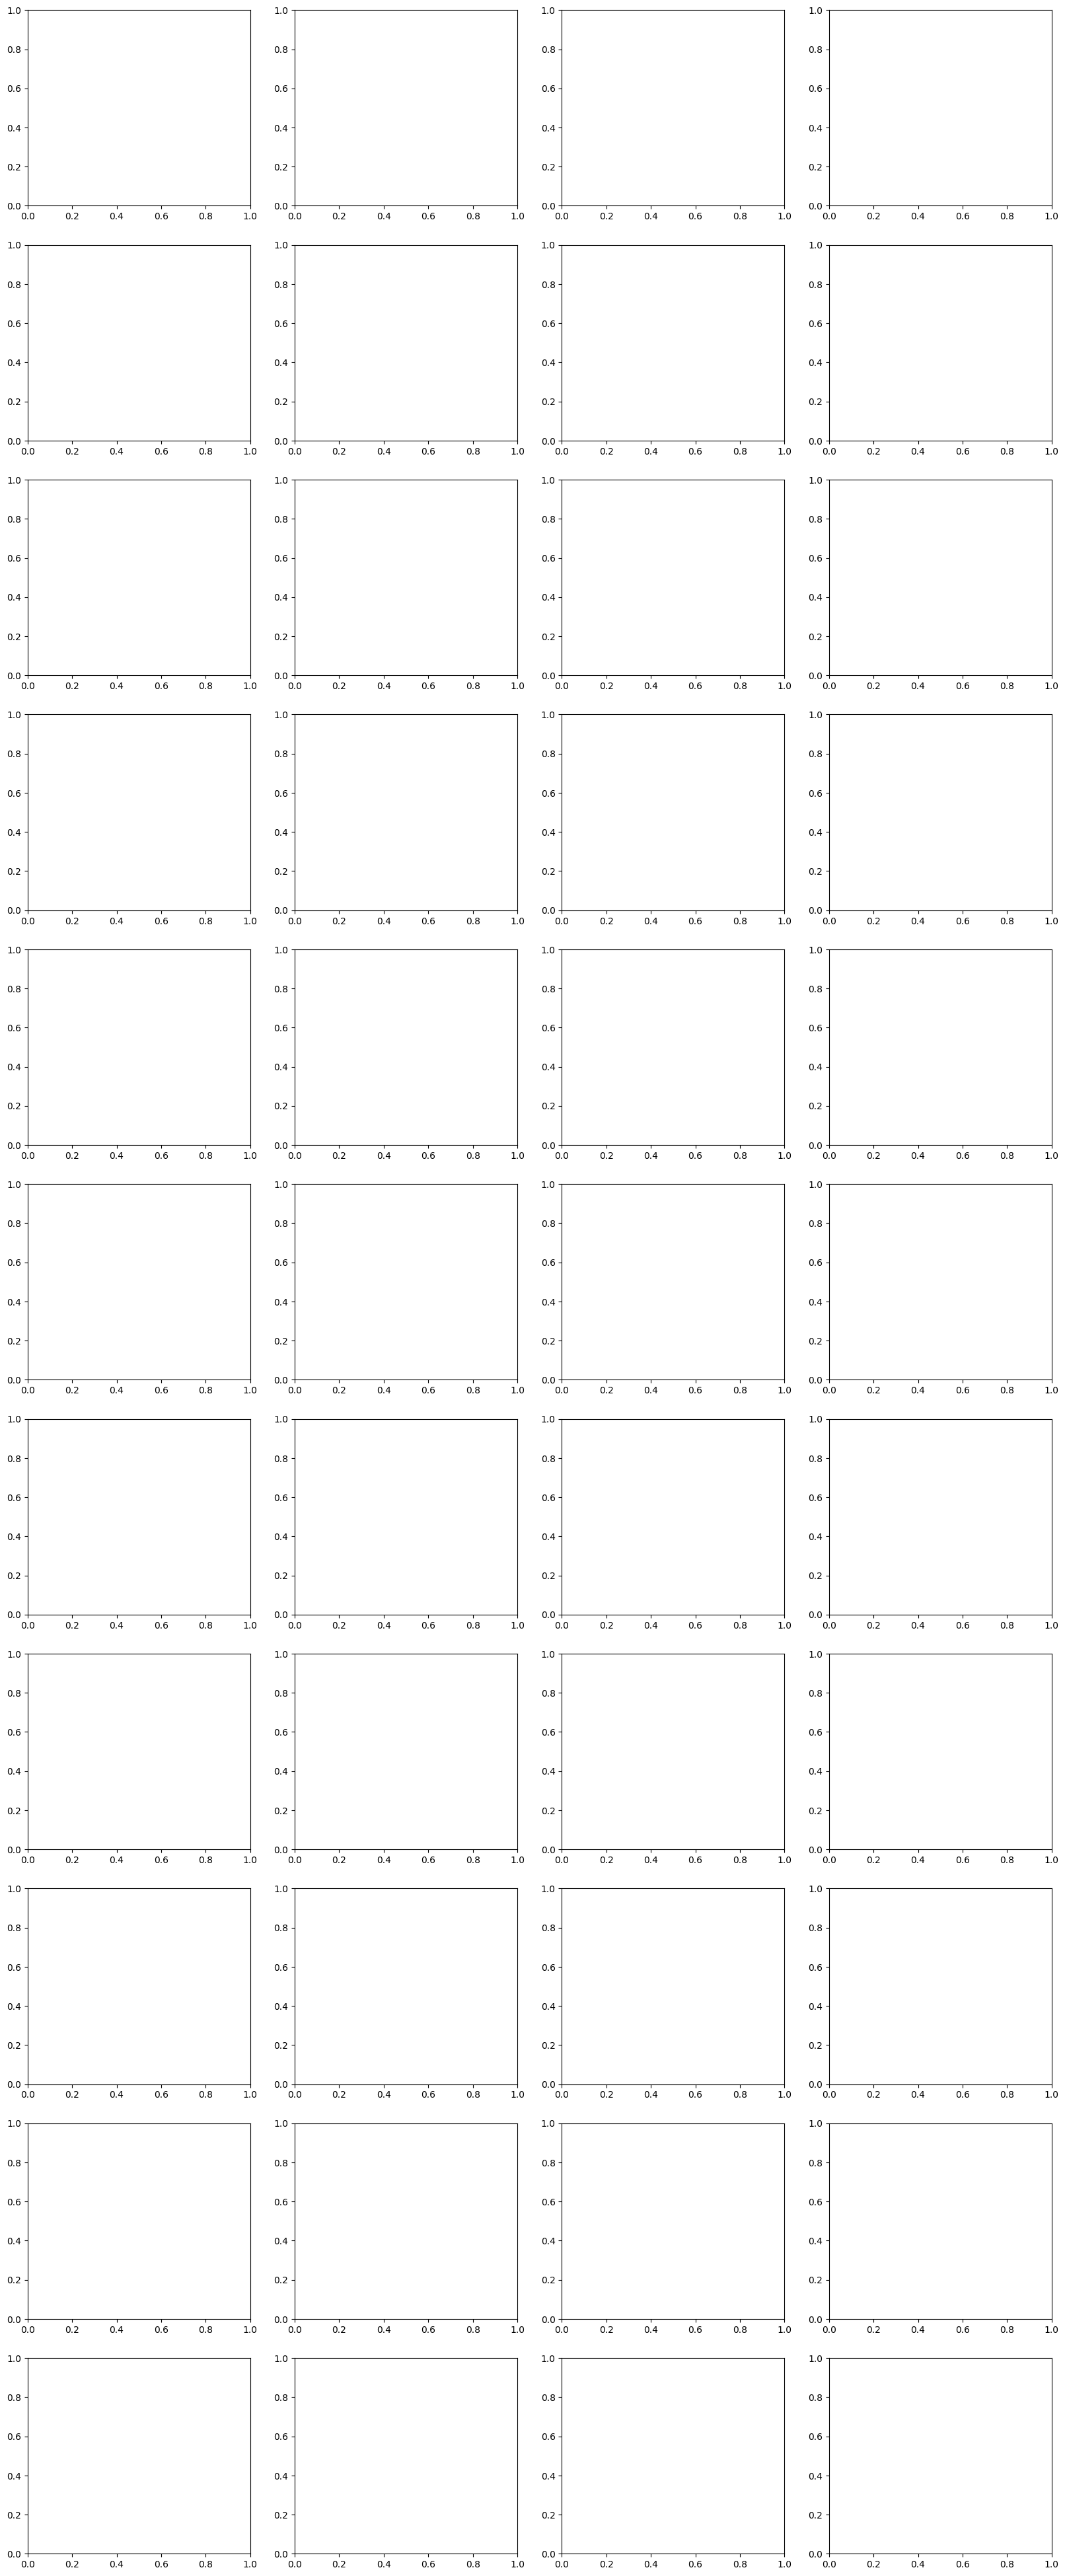

In [152]:
fig = plt.figure(figsize=(20,50)) # W x H
axes = fig.subplots(11,4)
i = 0
j = 0
for col in data:
  sns.boxplot(x=data['match'], 
              y = data[col], 
              data=data, 
              ax=axes[i,j], 
              palette='GnBu')
  axes[i,j].set_title(f'{col} Box Plot')
  i+=1
  j+=1
  if j == 4: j=0
  if i == 11: i=0
fig.tight_layout()
plt.show()

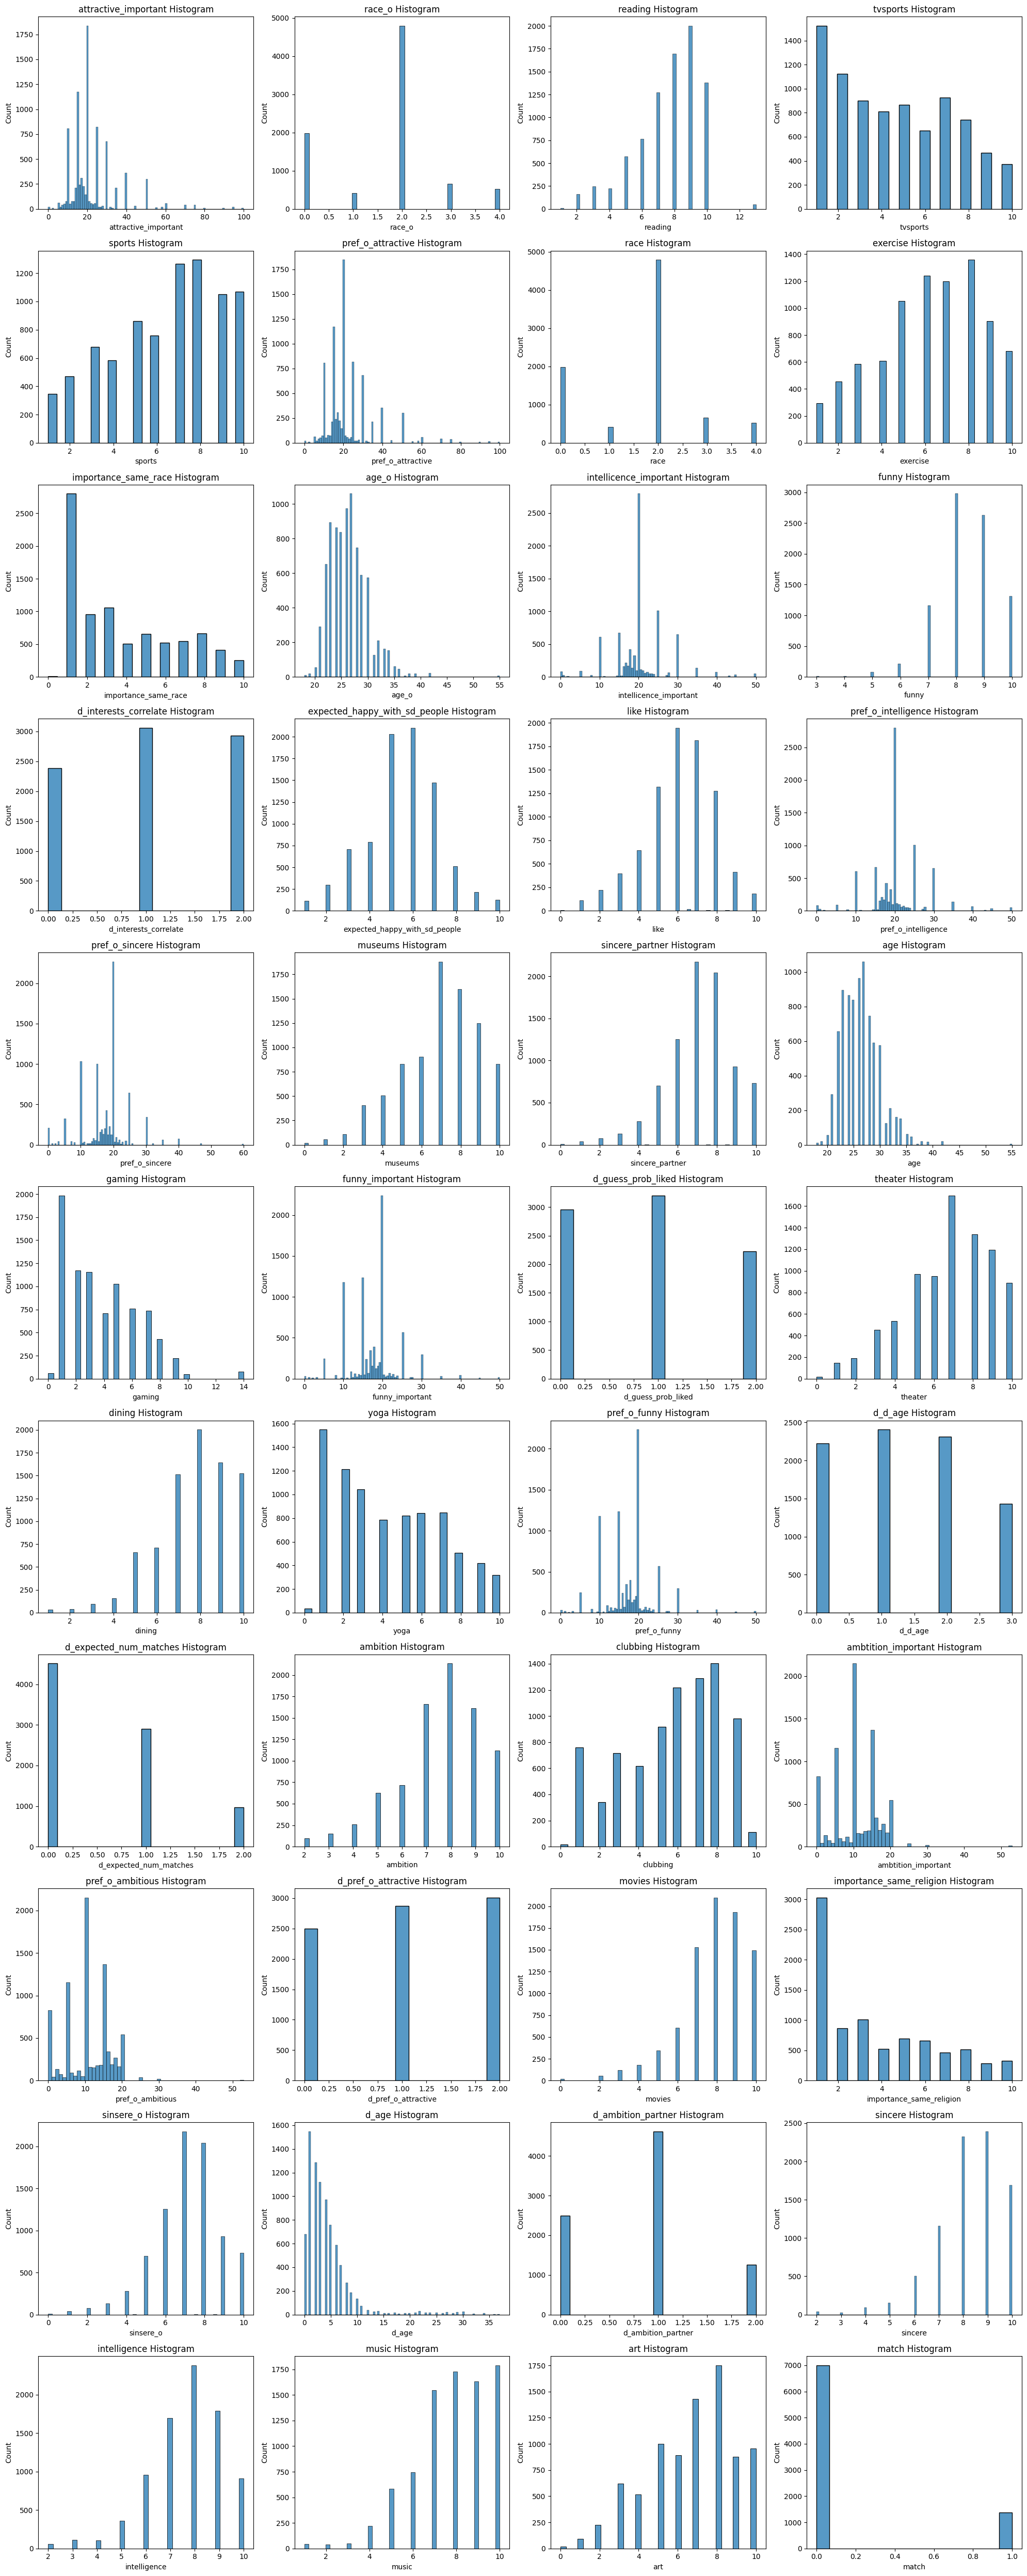

In [16]:
fig = plt.figure(figsize=(20,50)) # W x H
axes = fig.subplots(11,4)
i = 0
j = 0
for col in data:
  sns.histplot(data=data[col], 
              stat='count',
              ax=axes[i,j])
  axes[i,j].set_title(f'{col} Histogram')
  i+=1
  j+=1
  if j == 4: j=0
  if i == 11: i=0
fig.tight_layout()
plt.show()

In [29]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler().set_output(transform='pandas')
scaled = scaler.fit_transform(data)

scaled

,attractive_important,pref_o_attractive,intellicence_important,pref_o_intelligence,pref_o_sincere,funny_important,pref_o_funny,ambtition_important,pref_o_ambitious,d_age,...,race,funny,d_interests_correlate,museums,d_guess_prob_liked,d_d_age,d_expected_num_matches,d_pref_o_attractive,d_ambition_partner,match
0,0.15,0.35,0.4,0.40,0.333333,0.3,0.40,0.283019,0.000000,0.162162,...,0.0,0.714286,0.5,0.1,0.5,0.666667,0.5,1.0,0.5,0.0
1,0.15,0.60,0.4,0.00,0.000000,0.3,0.80,0.283019,0.000000,0.027027,...,0.0,0.714286,1.0,0.1,0.5,0.000000,0.5,1.0,0.0,0.0
2,0.15,0.19,0.4,0.38,0.300000,0.3,0.36,0.283019,0.264151,0.027027,...,0.0,0.714286,0.5,0.1,0.0,0.000000,0.5,0.5,0.0,1.0
3,0.15,0.30,0.4,0.30,0.083333,0.3,0.80,0.283019,0.094340,0.054054,...,0.0,0.714286,1.0,0.1,0.5,0.333333,0.5,1.0,0.5,1.0
4,0.15,0.30,0.4,0.40,0.166667,0.3,0.20,0.283019,0.188679,0.081081,...,0.0,0.714286,0.5,0.1,0.5,0.333333,0.5,1.0,0.5,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8373,0.70,0.10,0.3,0.60,0.166667,0.3,0.40,0.000000,0.188679,0.027027,...,0.5,0.571429,1.0,1.0,0.5,0.000000,0.5,0.0,0.0,0.0
8374,0.70,0.50,0.3,0.20,0.333333,0.3,0.10,0.000000,0.188679,0.027027,...,0.5,0.571429,1.0,1.0,0.0,0.000000,0.5,1.0,0.0,0.0
8375,0.70,0.40,0.3,0.60,0.166667,0.3,0.20,0.000000,0.188679,0.108108,...,0.5,0.571429,0.0,1.0,0.5,0.666667,0.5,1.0,0.5,0.0
8376,0.70,0.10,0.3,0.50,0.416667,0.3,0.20,0.000000,0.188679,0.081081,...,0.5,0.571429,1.0,1.0,0.5,0.333333,0.5,0.0,0.0,0.0


In [36]:
def min_max_scaling(data):
    
    min_values = np.min(data, axis=0)
    max_values = np.max(data, axis=0)
    return (data - min_values) / (max_values - min_values)

normalization = min_max_scaling(data)
# normalization.head(10)  


attractive_important              0.0
pref_o_attractive                 0.0
intellicence_important            0.0
pref_o_intelligence               0.0
pref_o_sincere                    0.0
funny_important                   0.0
pref_o_funny                      0.0
ambtition_important               0.0
pref_o_ambitious                  0.0
d_age                             0.0
art                               0.0
tvsports                          1.0
sports                            1.0
age_o                            18.0
like                              0.0
age                              18.0
gaming                            0.0
yoga                              0.0
clubbing                          0.0
importance_same_religion          1.0
sinsere_o                         0.0
music                             1.0
reading                           1.0
exercise                          1.0
importance_same_race              0.0
expected_happy_with_sd_people     1.0
sincere_part

In [31]:
print(scaled.equals(normalization))

False


In [18]:
def outliers(data):
   
    Q1 = np.percentile(data, 25, axis=0)
    Q3 = np.percentile(data, 75, axis=0)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return (data < lower_bound) | (data > upper_bound)

outliers = outliers(normalization)
outliers.head(10)

# Don't mind true and false for target. False means 0 and true means 1

,attractive_important,pref_o_attractive,intellicence_important,pref_o_intelligence,pref_o_sincere,funny_important,pref_o_funny,ambtition_important,pref_o_ambitious,d_age,...,race,funny,d_interests_correlate,museums,d_guess_prob_liked,d_d_age,d_expected_num_matches,d_pref_o_attractive,d_ambition_partner,match
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
1,False,True,False,True,True,False,True,False,False,False,...,False,False,False,True,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True
3,False,False,False,False,True,False,True,False,False,False,...,False,False,False,True,False,False,False,False,False,True
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True
5,False,True,False,False,True,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
6,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
7,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
8,False,True,False,False,True,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True
9,False,True,False,True,True,False,True,False,False,False,...,False,False,False,True,False,False,False,False,False,False
